In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx

In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(10):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

In [3]:
def get_dependency_cycle(tdd,reduced=False):
    n = (tdd.node.key+1)//2
    G = nx.Graph()
    for k in range(n):
        the_map1,w1 = get_downward_k_level_map(tdd,k,0)
        the_map2,w2 = get_downward_k_level_map(tdd,k,1)
        if the_map1.level!= 2*n-2-2*k:
            G.add_edge(2*n-1-2*k, 2*n-2-2*k,map={'x': 0, 'rotate': 0,'w':(w1,w2)})
        else:
            G.add_edge(2*n-1-2*k, 2*n-2-2*k,map={'x': the_map1.x, 'rotate': the_map1.rotate,'w':(w1,w2)})
        
        while the_map1.level>-1:
            if the_map1.level<2*n-2-2*k:
                if not reduced or (the_map1.level)%2==0:
                    G.add_edge(2*n-1-2*k, the_map1.level,map={'x': the_map1.x, 'rotate': the_map1.rotate})
            the_map1=the_map1.father
        while the_map2.level>-1:
            if the_map2.level<2*n-2-2*k:
                if not reduced or (the_map2.level)%2==1:
                    G.add_edge(2*n-2-2*k, the_map2.level,map={'x': the_map2.x, 'rotate': the_map2.rotate})
            the_map2=the_map2.father

    return G

def get_dependency_cycle2(tdd,reduced=False,G=None):
    n = (tdd.node.key+1)//2
    if G==None:
        G = nx.Graph()
    if tdd.node.key<=0:
        return G
    else:
        the_map1,w1 = tdd.node.out_maps[0],tdd.node.out_weight[0]
        the_map2,w2 = tdd.node.out_maps[1],tdd.node.out_weight[1]
        # k=int(tdd.key_2_index[tdd.node.key][1:])
        if the_map1.level!= tdd.node.key-1:
            if tdd.node.key%2==1:
                G.add_edge(tdd.node.key, tdd.node.key-1,map={'x': 0, 'rotate': 0,'w':(w1,w2)})
        else:
            if tdd.node.key%2==1:
                G.add_edge(tdd.node.key, tdd.node.key-1,map={'x': the_map1.x, 'rotate': the_map1.rotate,'w':(w1,w2)})
        
        while the_map1.level>-1:
            if the_map1.level<tdd.node.key:
                if not reduced or (the_map1.level)%2!=tdd.node.key%2:
                    G.add_edge(tdd.node.key, the_map1.level,map={'x': the_map1.x, 'rotate': the_map1.rotate})
            the_map1=the_map1.father
        while the_map2.level>-1:
            if the_map2.level<tdd.node.key:
                if not reduced or (the_map2.level)%2!=tdd.node.key%2:
                    G.add_edge(tdd.node.key, the_map2.level,map={'x': the_map2.x, 'rotate': the_map2.rotate})
            the_map2=the_map2.father
        if tdd.node.successor[0]==tdd.node.successor[1]:
            G=get_dependency_cycle2(Slicing(tdd,tdd.node.key,0),reduced,G)
        else:
            G=get_dependency_cycle2(Slicing(tdd,tdd.node.key,0),reduced,G)
            G=get_dependency_cycle2(Slicing(tdd,tdd.node.key,1),reduced,G)

    return G

def reduce_graph(tdd,G):
    n = (tdd.node.key+1)//2
    flag = True
    while flag:
        flag = False
        for idx in range(2*n-1,-1,-1):
            if idx in G:
                A = list(G.neighbors(idx))
                if len(A)==1:
                    G.remove_node(idx)
                    G.remove_node(A[0])
                    flag = True
    return G

In [4]:
def eliminate_global_map(tdd):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if idx%2==1:
            if the_map.rotate>0:
                cir_head.p(np.pi/4*(8-the_map.rotate),q)
            if the_map.x==1:
                cir_head.x(q)
        else:
            if the_map.x==1:
                cir_end.x(q)
            if the_map.rotate>0:
                cir_end.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end

In [5]:
def get_border_control_pos(tdd,G):
    res = []
    for idx in range(tdd.node.key,-1,-1):
        A = list(G.neighbors(idx))
        for idx2 in A:
            if idx2%2==idx%2 and idx2<idx:
                res.append([idx,idx2])
    return res
            

def eliminate_border_control(tdd,G=None):

    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_border_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for [idx1,idx2] in res:
        q_c = int(tdd.key_2_index[idx1][1:])
        q = int(tdd.key_2_index[idx2][1:])
        # print(q_c,q)
        temp_map = G.edges[idx1,idx2]['map']
        if idx1%2==1:
            if temp_map['rotate']>0:
                cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            if temp_map['x']==1:
                cir_head.cx(q_c,q)
        else:
            if temp_map['x']==1:
                cir_end.cx(q_c,q)
            if temp_map['rotate']>0:
                cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t 
    return tdd_new,cir_head,cir_end

In [6]:
def get_sigle_qubit_gates(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if not idx in G:
            continue
        A = list(G.neighbors(idx))
        idx1=-1

        if len(A)==1:
            if idx%2==1:
                idx1=idx
            elif not (idx+1) in res:
                idx1=idx+1
            if idx1==-1:
                continue

            temp_map = G.edges[idx1,idx1-1]['map']
            w = temp_map['w']
            M = np.zeros([2,2],dtype=complex)
            M[0][0]=M[0][1]=1
            a = w[1]
            M[1][0] = a
            if temp_map['rotate']>0:
                a*=np.exp(1j*np.pi/4*(temp_map['rotate']))
                M[1][1]=a
            if temp_map['x']==1:
                M[0][1],M[1][1] = M[1][1],M[0][1]
            # print(M)
            M/= np.sqrt(abs(M[0][0])**2+abs(M[0][1])**2)
            # print(M)
            if M[0][0]==M[1][1]==1:
                continue
            M_conj=M.T.conjugate()
            err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
            if err>1e-8:
                print('Not Unitary')
                continue
            M=M_conj
            res[idx] = M
    return res


def eliminate_sigle_qubit_gates(tdd,G=None):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    if G==None:
        G = get_dependency_cycle(tdd)

    res = get_sigle_qubit_gates(tdd,G)
    # print('a',res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for idx in res:
        q = int(tdd.key_2_index[idx][1:])
        M = res[idx]
        # print(q,M)
        if idx%2==1:
            cir_head.unitary(M,q)
        else:
            cir_end.unitary(M,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t

    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print('b',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t        
    return tdd_new,cir_head,cir_end

In [7]:
def get_partial_control_pos(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if idx%2==1:
            A = list(G.neighbors(idx))
            B = list(G.neighbors(idx-1))
            if len(A)>1 and len(B)==1:
                # print(idx,A,B)
                A.remove(idx-1)
                B.remove(idx)
                if len(A)>0 or len(B)>0:
                    res[idx] = A+B
        else:
            A = list(G.neighbors(idx))
            B = list(G.neighbors(idx+1))
            if len(A)>1 and len(B)==1:
                A.remove(idx+1)
                B.remove(idx)
                if len(A)>0 or len(B)>0:
                    res[idx] = A+B
                
    return res
            

def eliminate_partial_control(tdd,G=None):

    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_partial_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
    calculted = []
    for idx1 in res:
        for idx2 in res[idx1]:
            if [idx2,idx1] in calculted:
                continue
            # print(idx1,idx2)
            q_c = int(tdd.key_2_index[max(idx1,idx2)][1:])
            q = int(tdd.key_2_index[min(idx1,idx2)][1:])
            # print(q_c,q)
            temp_map = G.edges[idx1,idx2]['map']
            if idx2%2==1:
                if temp_map['rotate']>0:
                    cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
                if temp_map['x']==1:
                    cir_head.cx(q_c,q)
            else:
                if temp_map['x']==1:
                    cir_end.cx(q_c,q)
                if temp_map['rotate']>0:
                    cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            calculted.append([idx1,idx2])
    # print(cir_head)
    # print(cir_end)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print('aa',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [8]:
def find_entangel_indices(tdd,G=None,calculated=[]):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd,True)
    G = reduce_graph(tdd,G)

    idxs = []
    
    cycles = list(nx.cycle_basis(G))
    # print(G)
    # print(cycles,'aa')
    if not cycles:
        return idxs

    idxs = []
    # for l in range(len(cycles)):
    #     cycles[l].sort()
    #     cycles[l].reverse()
    #     # print(cycles[l])
    #     idx1=-1
    #     for idx0 in cycles[l]:
    #         A = list(G.neighbors(idx0))
    #         for k in range(idx0-1,-1,-1):
    #             if k in cycles[l] and k in A and k//2!=idx0//2:
    #                 idx1=k
    #                 if not [idx0,idx1] in calculated:
    #                     # if [idx0,idx1] not in idxs:
    #                         idxs.append([idx0,idx1])
    #                     # if idx0%2==1:
    #                     #     if [idx0-1,idx1+1] not in idxs:
    #                     #         idxs.append([idx0-1,idx1+1])
    #                     # if idx0%2==0:
    #                     #     if [idx0+1,idx1-1] not in idxs:
    #                     #         idxs.append([idx0+1,idx1-1])

    A=[]
    for l in range(len(cycles)):
        for x in cycles[l]:
            if not x in A:
                A.append(x)
    A.sort()
    A.reverse()
    for k in A:
        for k1 in range(k-1,-1,-1):
            if k1 in A and tdd.key_2_index[k][1:]!=tdd.key_2_index[k1][1:] and k%2!=k1%2:
                idxs.append([k,k1])
    return idxs

def eliminate_entangel_through_swap(tdd,G=None,calculated1={}):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    if tdd.node_number()>2*n+1:
        print('Is not tower form in en')
        # return tdd,cir_head,cir_end      
    if G==None:
        G = get_dependency_cycle(tdd,True)
        
    idxs = find_entangel_indices(tdd,G,calculated=[])
    # print(idxs)
    if len(idxs)==0:
        return tdd,cir_head,cir_end
    
    
    
    flag = False
    id0=0
    id1=0
    for [idx0,idx1] in idxs:
        if tdd.node in calculated1:
            if [idx0,idx1] in calculated1[tdd.node]:
                continue
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)        
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        # print(idx0,idx1,q0,q1)
        if idx0%2==1:
            cir_head_t.cx(q0,q1)
            cir_head_t.cx(q1,q0)
            cir_head_t.cx(q0,q1)
        else:
            cir_end_t.cx(q0,q1)
            cir_end_t.cx(q1,q0)
            cir_end_t.cx(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
        G_t = get_dependency_cycle(tdd_new_t,True)
        G_t = reduce_graph(tdd_new_t,G_t)
        
        if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
            flag = True
            break
    # if not flag:
    #     for [idx0,idx1] in idxs:
    #         if tdd.node in calculated1:
    #             if [idx0,idx1] in calculated1[tdd.node]:
    #                 continue
    #         cir_head_t = QuantumCircuit(n)
    #         cir_end_t = QuantumCircuit(n)        
    #         q0=int(tdd.key_2_index[idx0][1:])
    #         q1=int(tdd.key_2_index[idx1][1:])
    #         cir_head_t.ch(q0,q1)
    #         tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
    #         tdd_new_t = renormalize(tdd_new_t)
    #         G_t = get_dependency_cycle(tdd_new_t,True)
    #         G_t = reduce_graph(tdd_new_t,G_t)
    #         if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
    #             flag = True
    #             break
    #         cir_head_t = QuantumCircuit(n)
    #         cir_head_t.ch(q1,q0)
    #         tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
    #         tdd_new_t = renormalize(tdd_new_t)
    #         G_t = get_dependency_cycle(tdd_new_t,True)
    #         G_t = reduce_graph(tdd_new_t,G_t)
    #         if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
    #             flag = True
    #             break

    #         cir_end_t.ch(q0,q1)
    #         tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
    #         tdd_new_t = renormalize(tdd_new_t)
    #         G_t = get_dependency_cycle(tdd_new_t,True)
    #         G_t = reduce_graph(tdd_new_t,G_t)
    #         if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
    #             flag = True
    #             break
    #         cir_end_t = QuantumCircuit(n)
    #         cir_end_t.ch(q1,q0)
    #         tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
    #         tdd_new_t = renormalize(tdd_new_t)
    #         G_t = get_dependency_cycle(tdd_new_t,True)
    #         G_t = reduce_graph(tdd_new_t,G_t)
    #         if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
    #             flag = True
    #             break

    if not flag:
        [idx0,idx1] = idxs[0]
        print(idxs[0])
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)            
        cir_head_t.h(q1)
        cir_head_t.cz(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
 
    
    if not flag:
        print('Not find one')


    if not tdd.node in calculated1:
        calculated1[tdd.node] = [[id0,id1]]
    else:
        calculated1[tdd.node].append([id0,id1])

    tdd_new = tdd_new_t
    cir_head = cir_head_t
    cir_end = cir_end_t
    # print(cir_head,cir_end)

    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    # print(11,res)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(22,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print(33,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t   

    G2 = get_dependency_cycle(tdd_new,True)
    idxs=find_entangel_indices(tdd,G2,calculated=[])
    # print(44,idx0,idx1)
    if idxs:
        tdd_new,cir_head_t,cir_end_t = eliminate_entangel_through_swap(tdd_new,G=None,calculated1=calculated1)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [9]:
def test_ch(tdd,G=None,calculated1={}):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd,True)
        
    idxs = find_entangel_indices(tdd,G,calculated=[])
    print(idxs)
    if len(idxs)==0:
        return tdd,cir_head,cir_end
    
    
    
    flag = False
    id0=0
    id1=0
    for [idx0,idx1] in idxs:
        if tdd.node in calculated1:
            if [idx0,idx1] in calculated1[tdd.node]:
                continue
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)        
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        # print(idx0,idx1,q0,q1)
        if idx0%2==1:
            cir_head_t.cx(q0,q1)
            cir_head_t.cx(q1,q0)
            cir_head_t.cx(q0,q1)
        else:
            cir_end_t.cx(q0,q1)
            cir_end_t.cx(q1,q0)
            cir_end_t.cx(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
        G_t = get_dependency_cycle(tdd_new_t,True)
        G_t = reduce_graph(tdd_new_t,G_t)
        
        if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
            flag = True
            print(idx0,idx1,q0,q1)
            break
    if not flag:
        print(1)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)        
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t.ch(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_head_t.ch(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.ch(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.ch(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break

    if not flag:
        print(2)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)        
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t.h(q1)
            cir_head_t.cz(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_head_t.h(q0)
            cir_head_t.cz(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q1)
            cir_end_t.cz(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q0)
            cir_end_t.cz(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
    if not flag:
        print(3)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue       
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)              
            cir_head_t.h(q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break

            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)              
            cir_head_t.h(q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t,True)
            G_t = reduce_graph(tdd_new_t,G_t)
            if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break       
    
    if not flag:
        print('Not find one')
    print(tdd_new_t.map)
    tdd_new = tdd_new_t
    cir_head = cir_head_t
    cir_end = cir_end_t

    return tdd_new,cir_head,cir_end

In [10]:
def syn_tower(tdd):
    """逐层去处理各个level"""
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    tdd_new = tdd.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 1')
        # return tdd_new,cir_head,cir_end
        
    tdd_new,cir_head_t,cir_end_t=eliminate_global_map(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 2')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_border_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 3')
        # return tdd_new,cir_head,cir_end

    tdd_new,cir_head_t,cir_end_t=eliminate_sigle_qubit_gates(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 4')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_partial_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 5')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_entangel_through_swap(tdd_new,calculated1={})
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 6')
        # return tdd_new,cir_head,cir_end
    for k in range(n):
        the_map1,_ = get_downward_k_level_map(tdd_new,k,0)
        # print(the_map1.level,the_map1.father.level)
        if the_map1.level != 2*n-2-2*k or the_map1.father.level!=-1 or the_map1.x==0 or the_map1.rotate>0:
            tdd_new,cir_head_t,cir_end_t = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
        the_map2,_ = get_downward_k_level_map(tdd_new,k,1)
        # print(the_map2.level)
        if the_map2.level!=-1:
            tdd_new,cir_head_t,cir_end_t = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [11]:
#当纠缠没有消掉的时候，1选择其他的方案消掉2，先处理别的比特
#当有分支的时候有两种情况，一种是两支只差一点点，加一个多比特门就能化回去
#另一个是最左边分支已经变成单位矩阵，其它分支需要加条件慢慢变过来

def get_sub_dd(tdd,split_idx=[0,0]):
    tdd_new = tdd.self_copy()

    for k in split_idx:
        tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    # flag = False
    # for k in split_idx:
    #     if not flag:
    #         if tdd_new.node.successor[0]!=tdd_new.node.successor[1]:
    #             flag=True
    #         tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    #         print(k)
    #     else:
    #         if tdd_new.node.out_maps[k].level==-1 and tdd_new.node.out_maps[1-k].level!=-1:
    #             print(1-k)
    #             tdd_new = Slicing2(tdd_new,tdd_new.node.key,1-k)
    #         else:
    #             tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    #             print(k)

    n = (tdd_new.node.key+1)//2
    print('New Qubits:',n)
    tdd_new.index_set = []
    tdd_new.key_2_index ={-1:-1}
    tdd_new.key_width = {}
    for k in range(n):
        tdd_new.index_set.append(Index('x'+str(k),0))
        tdd_new.index_set.append(Index('y'+str(k),0))
        tdd_new.key_2_index[2*k] = 'y'+str(n-k-1)
        tdd_new.key_2_index[2*k+1] = 'x'+str(n-k-1)
        tdd_new.key_width[2*k] = 2
        tdd_new.key_width[2*k+1] = 2
    tdd_new.index_2_key = {tdd_new.key_2_index[a]:a for a in tdd_new.key_2_index}
    
    # print(tdd_new.key_2_index)
    # print(tdd_new.index_2_key)
    # print(tdd_new.key_width)

    # for k in tdd_new.index_set:
    #     print(k)
    return tdd_new

def get_controlled_circuit(cir,cond=[1]):

    add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(add_qubits_num)
        new_qubits = list(range(add_qubits_num))
        for k in qargs:
            new_qubits.append(k.index+add_qubits_num)
        circ.append(cg,new_qubits)
    for k in range(add_qubits_num):
        if cond[k]==0:
            circ.x(k)
            temp_cir = QuantumCircuit(cir.num_qubits+add_qubits_num)
            temp_cir.x(k)
            circ=temp_cir&circ
    return circ

def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
    if add_qubits_num==0:
        add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(len(cond))
        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index+add_qubits_num)
        circ.append(cg,new_qubits)
    for k in cond:
        if cond[k]==0:
            circ.x(k)
            temp_cir = QuantumCircuit(cir.num_qubits+add_qubits_num)
            temp_cir.x(k)
            circ=temp_cir&circ
    return circ

def is_reduced(tdd):
    
    if tdd.node.key==-1:
        return True

    if tdd.node.key%2==1:
        if tdd.node.successor[0]!=tdd.node.successor[1]:
            return False
        the_map1,_ = get_downward_k_level_map(tdd,0,0)
        if the_map1.level!=tdd.node.key-1:
            return False
        if the_map1.father.level!=-1:
            return False
        return is_reduced(Slicing2(tdd,tdd.node.key,0))
    else:
        if tdd.node.successor[0]!=tdd.node.successor[1]:
            return False
        if tdd.node.out_weight[1]!=0:
            return False
        return is_reduced(Slicing2(tdd,tdd.node.key,0))

def get_leftmost_split_path(tdd):
    
    if tdd.node.key==-1:
        return {}

    if is_reduced(tdd):
        return {}
    
    if tdd.node.successor[0]==tdd.node.successor[1]:
        return get_leftmost_split_path(Slicing2(tdd,tdd.node.key,0))

    if is_reduced(Slicing2(tdd,tdd.node.key,0)):
        split_pos = get_leftmost_split_path(Slicing2(tdd,tdd.node.key,1))
        split_pos[tdd.node.key]=1
    else:
        split_pos = get_leftmost_split_path(Slicing2(tdd,tdd.node.key,0))
        split_pos[tdd.node.key]=0
    return split_pos

def merge_lefrmost_split(tdd):
    split_pos = get_leftmost_split_path(tdd)

    for k in split_pos:
        if k%2==0:
            print(split_pos)
            print('Even Exist!')
    print(split_pos)
    split_path = []
    if len(split_pos)>0:
        for k in range(tdd.node.key,min(split_pos)-2,-1):
            if k in split_pos:
                split_path.append(split_pos[k])
            else:
                split_path.append(0)
    print(split_path)
    tdd_new=get_sub_dd(tdd,split_path)
    if tdd_new.weight==0:
        tdd_new.weight=1
    tdd_new,cir_head,cir_end=syn_tower(tdd_new)

    n = (tdd.node.key+1)//2
    n2 = (tdd_new.node.key+1)//2
    control_cond = {}
    for k in split_pos:
        control_cond[n-(k+1)//2] = split_pos[k]
    print(control_cond,n-n2)
    cir_head2 = get_controlled_circuit2(cir_head,control_cond,n-n2)
    cir_end2 = get_controlled_circuit2(cir_end,control_cond,n-n2)
    
    tdd_new2 = update_tdd(tdd,cir_head2,cir_end2)
    tdd_new2 = renormalize(tdd_new2)
    return tdd_new2,cir_head2,cir_end2

def merge_split(tdd):
    n = (tdd.node.key+1)//2
    tdd_new = tdd.self_copy()
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
    tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
    tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
    tdd_new,_,_=eliminate_entangel_through_swap(tdd_new,calculated1={})
    while not is_reduced(tdd_new):
        tdd_new,cir_head2,cir_end2 = merge_lefrmost_split(tdd_new)
        cir_head = cir_head2&cir_head
        cir_end = cir_end&cir_end2
        # break
    return tdd_new,cir_head,cir_end

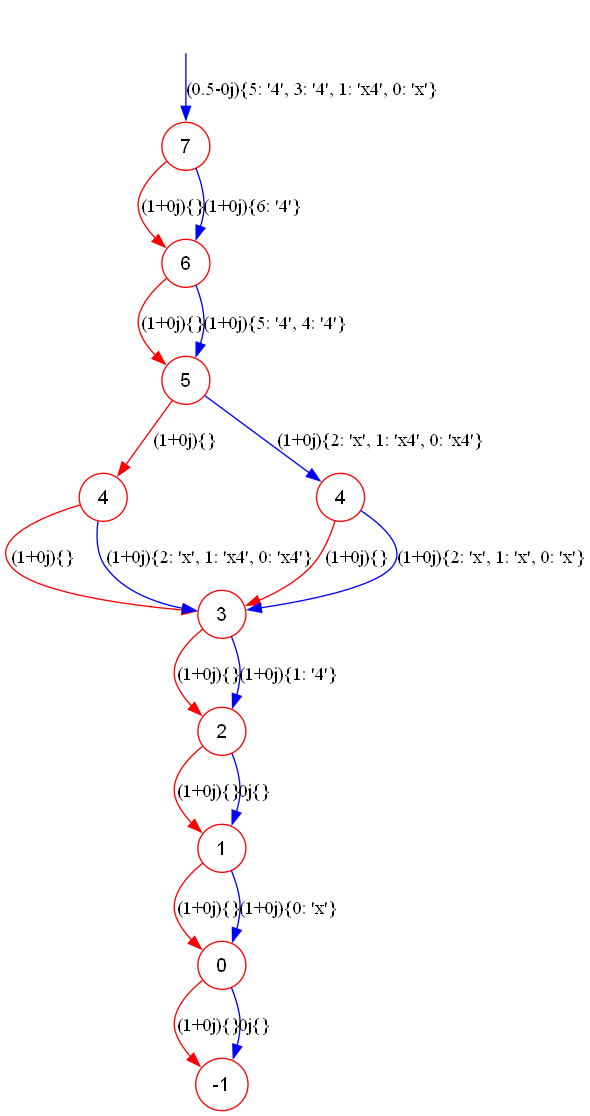

In [12]:
n=4
m=20

cir=gen_cir('Random_Clifford',n,m)
tdd=simulate(cir,True)
tdd.show(False)

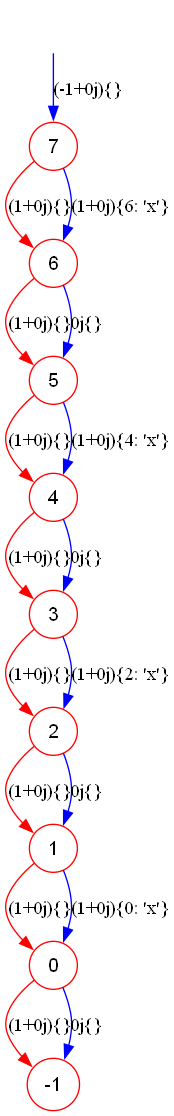

In [13]:
id_tdd,cir_head,cir_end=syn_tower(tdd)
id_tdd.show(False)

In [14]:
tdd_new2=None
flag=True
# for k in range(100):
k=0
while flag:
    print(k)
    k+=1
    if k>1000:
        break
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,False)
    # print(tdd2.node.key,tdd2.node_number())
    if tdd2.node.key!=2*n-1:
        continue
    if tdd2.node_number()>9:
        print('-')
        # break
        
        # continue
    # print(1)
    # tdd_new2,cir_head,cir_end = syn_tower(tdd2)
    tdd_new2,cir_head,cir_end = merge_split(tdd2)
    # if tdd_new2.node_number()>9 or tdd_new2.node.key!=2*n-1:
    #     continue
    if tdd_new2.node!=id_tdd.node or tdd_new2.map.level!=-1:
        flag=False
        print('Find one')
        break
tdd_new2.show(False)

0
-
Is not tower form in en
{5: 1}
[0, 0, 1, 0]
New Qubits: 2
{1: 1} 2
1
-
2
3
4
5
6
7
8
9
-
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
10
11
-
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
12
13
14
15
16
-
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
17
18
19
-
20
-
21
22
23
-
24
-
Is not tower form in en
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
25
26
27
28
29
30
-
31
32
33
34
35
36
37
38
39
-
Is not tower form in en
[7, 0]
Not find one
40
41
42
-
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
43
-
44
45
46
47
48
49
-
Is not tower form in en
{7: 1}
[1, 0]
New Qubits: 3
{0: 1} 1
50
51
52
53
54
-
55
56
-
57
-
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower form in en
Is not tower 


KeyboardInterrupt



In [15]:
# cir = QuantumCircuit.from_qasm_file('split2.qasm')
cir.draw()
# f=open('split2.qasm','w')
# f.write(qasm2.dumps(cir))
# f.close()

┌───┐                    ┌───┐┌───┐     
q_0: ┤ T ├─────────────────■──┤ Y ├┤ Y ├─────
     ├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐
q_1: ┤ X ├┤ S ├┤ X ├┤ S ├┤ X ├┤ X ├┤ T ├┤ H ├
     ├───┤├───┤└─┬─┘├───┤├───┤└─┬─┘├───┤└───┘
q_2: ┤ H ├┤ H ├──┼──┤ T ├┤ X ├──■──┤ Y ├─────
     └───┘└───┘  │  ├───┤├───┤┌───┐├───┤     
q_3: ────────────■──┤ Z ├┤ H ├┤ Y ├┤ H ├─────
                    └───┘└───┘└───┘└───┘

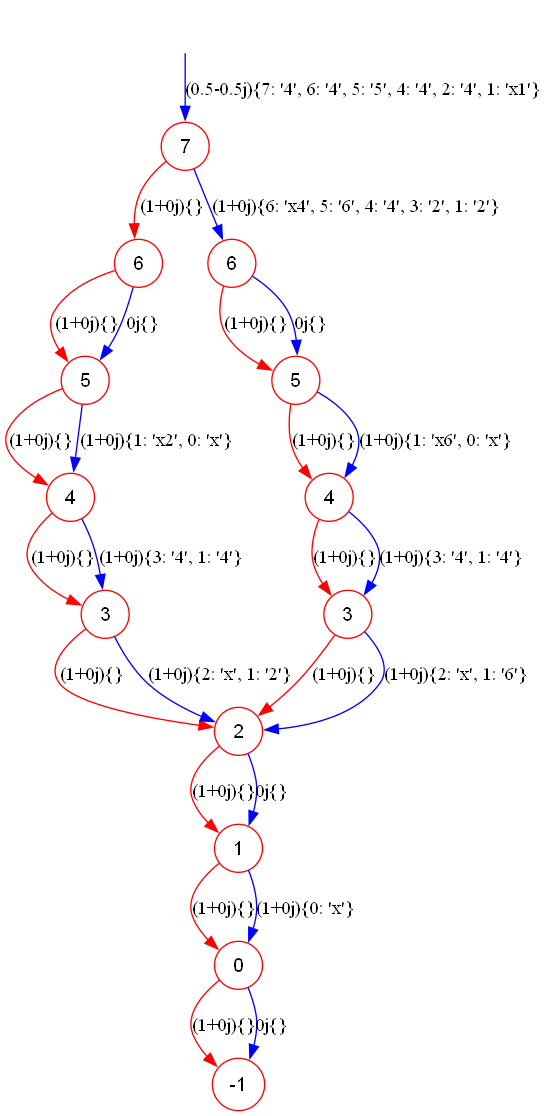

In [16]:
# cir=QuantumCircuit(2)
# cir.cx(1,0)
# cir.cx(0,1)
tdd2=simulate(cir,False)
tdd2.show(False)

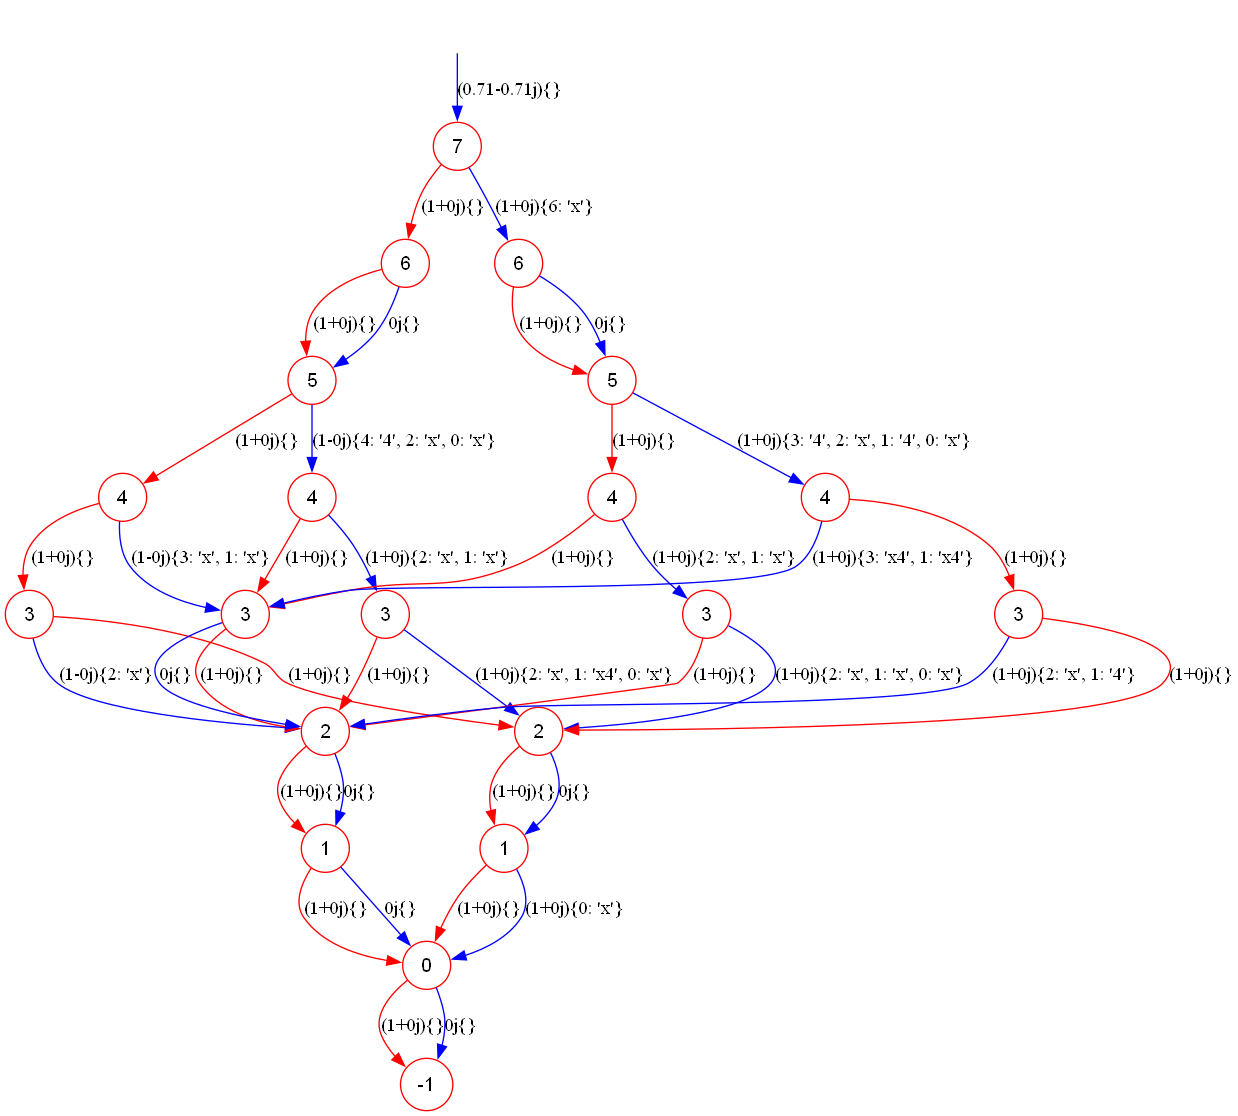

In [19]:
tdd_new,cir_head,cir_end=eliminate_global_map(tdd2)
tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
tdd_new.show(False)

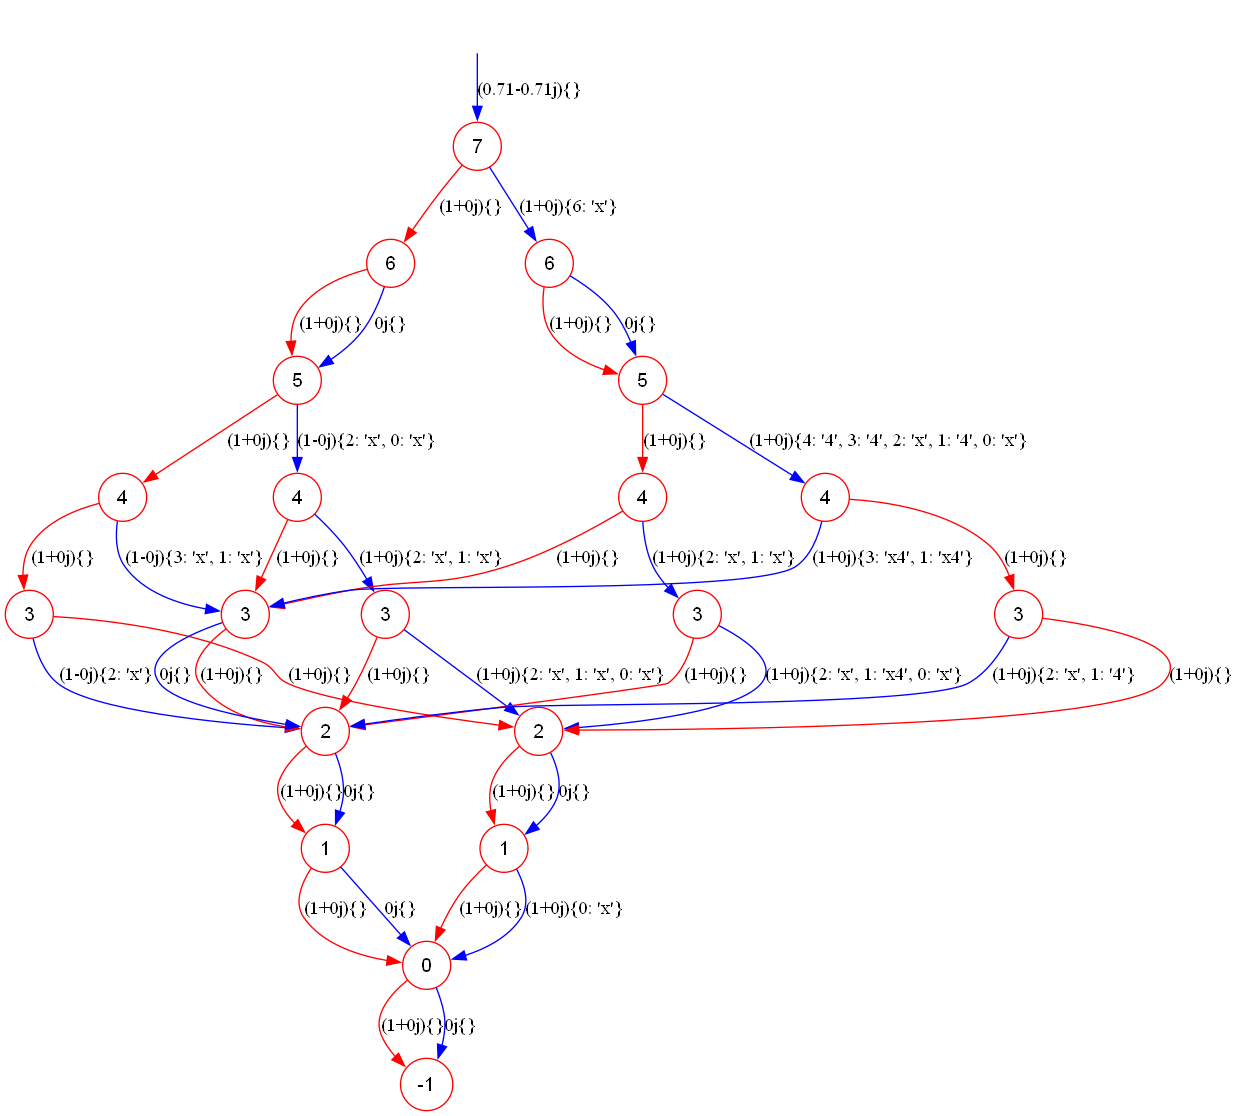

In [18]:
tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
tdd_new.show(False)

In [ ]:
tdd_new,_,_=eliminate_entangel_through_swap(tdd_new,calculated1={})
tdd_new.show(False)

In [ ]:
G = get_dependency_cycle2(tdd_new,True)
# G=reduce_graph(tdd_new,G)
# cycles = list(nx.cycle_basis(G))
# print(cycles)
nx.draw(G,with_labels=True)
print(find_entangel_indices(tdd_new))

In [ ]:
tdd_r,cir_head,cir_end = merge_split(tdd_new)
tdd_r.show(False)

In [ ]:
tdd_new.show(False)

In [ ]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)
# cir_head2.ccz(1,2,3)
# cir_head2.ccz(0,2,3)

q0=0
q1=1
h = 2

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)
# cir_head2.cy(1,0)

cir_end2.cx(0,3)
cir_head2.ccz(0,1,2)
# cir_end2.z(0)

tdd_new2 = update_tdd(tdd_new,cir_head2,cir_end2)
tdd_new2 = renormalize(tdd_new2)
tdd_new2.show(False)
# tdd_2,cir_head,cir_end=merge_split(tdd_new2)
# tdd_2.show(False)

In [ ]:
tdd_new3,cir_head,cir_end = test_ch(tdd_new3)
tdd_new3.show(False)